In [10]:
import pandas as pd
df = pd.read_csv('merc.csv')
df.shape

(13119, 9)

In [11]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,SLK,2005,5200,Automatic,63000,Petrol,325,32.1,1.8
1,S Class,2017,34948,Automatic,27000,Hybrid,20,61.4,2.1
2,SL CLASS,2016,49948,Automatic,6200,Petrol,555,28.0,5.5
3,G Class,2016,61948,Automatic,16000,Petrol,325,30.4,4.0
4,G Class,2016,73948,Automatic,4000,Petrol,325,30.1,4.0


Метод isna для каждой ячейки проверяет, пропущено в ней значение или нет.Затем
мы используем метод sum чтобы просуммировать количество пропусков в каждом
признаке.

In [12]:
df.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

Некоторые признаки не содержат пропусков. А в остальных их примерно равное
количество.Давайте посмотрим на процент пропусков в каждом признаке. Для
этого разделим значения на количество записей в датафрейме.

In [13]:
df.isna().sum() / df.shape[0]

model           0.0
year            0.0
price           0.0
transmission    0.0
mileage         0.0
fuelType        0.0
tax             0.0
mpg             0.0
engineSize      0.0
dtype: float64

Давайте просуммируем наши пропуски и посмотрим сколько же там пропущено
значений.

In [14]:
df_miss_row = df[df.isna().sum(axis=1) >= 5]
df_miss_row.shape

(0, 9)

Давайте их просто удалим из набора данных строки где пропусков меньше 5

In [15]:
df = df[df.isna().sum(axis=1) < 5]
df.shape

(13119, 9)

In [16]:
from sklearn.model_selection import train_test_split
random_state = 42
X_train, X_test = train_test_split(df, test_size=0.2, random_state=random_state)

Заполним пропуски в признаках налога и пробега заполним нулями, а в признаке
модели значением неизвестно. Ав признакаха расхода топлива и объема двигателя
- медианным значением этих признаков. В отличии от пробега и налога эти
признаки не могут быть равны нулю. Для начала импортируем предпроцессор,
который мы будем использовать для заполнения пропусков.

In [17]:
from sklearn.impute import SimpleImputer

In [23]:
imp_const_0 = SimpleImputer(strategy='constant', fill_value=0)

In [24]:
zero_cols = ['mileage', 'tax']

In [25]:
X_train[zero_cols] = imp_const_0.fit_transform(X_train[zero_cols])
X_train.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
7765,C Class,2019,34579,Semi-Auto,1000,Petrol,145,44.1,1.5
4007,GLE Class,2017,33142,Automatic,27661,Diesel,145,42.8,3.0
274,C Class,2018,20685,Semi-Auto,21929,Diesel,145,64.2,2.1
1281,C Class,2016,18700,Semi-Auto,33237,Diesel,125,58.9,2.1
6062,C Class,2019,29995,Semi-Auto,9,Petrol,145,42.8,2.0


Убедимся, что все пропуски были заполнены

In [22]:
X_train[zero_cols].isna().sum()

mileage    0
tax        0
dtype: int64

In [26]:
imp_const_unknown = SimpleImputer(strategy='constant', fill_value='unknown')
unk_cols = ['model']
X_train[unk_cols] = imp_const_unknown.fit_transform(X_train[unk_cols])
X_train.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
7765,C Class,2019,34579,Semi-Auto,1000,Petrol,145,44.1,1.5
4007,GLE Class,2017,33142,Automatic,27661,Diesel,145,42.8,3.0
274,C Class,2018,20685,Semi-Auto,21929,Diesel,145,64.2,2.1
1281,C Class,2016,18700,Semi-Auto,33237,Diesel,125,58.9,2.1
6062,C Class,2019,29995,Semi-Auto,9,Petrol,145,42.8,2.0


А теперь заполним пропуски в признаках, про которые мы говорили выше,
медианным значением.

In [28]:
imp_median = SimpleImputer(strategy='median')
med_cols = ['mpg', 'engineSize']
X_train[med_cols] = imp_median.fit_transform(X_train[med_cols])
X_train.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
7765,C Class,2019,34579,Semi-Auto,1000,Petrol,145,44.1,1.5
4007,GLE Class,2017,33142,Automatic,27661,Diesel,145,42.8,3.0
274,C Class,2018,20685,Semi-Auto,21929,Diesel,145,64.2,2.1
1281,C Class,2016,18700,Semi-Auto,33237,Diesel,125,58.9,2.1
6062,C Class,2019,29995,Semi-Auto,9,Petrol,145,42.8,2.0


У нас остался еще один признак с пропусками - год выпуска. Давайте используем
метод к ближайших соседей. Мы будем искать пропуски, а затем найдем соседей, и
посмотрим, какие значения там.

Будем брать трех ближайших соседей. Будем использовать только численные
признаки

In [30]:
from sklearn.impute import KNNImputer
imp_knn = KNNImputer(n_neighbors=3)
num_columns = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
#Пройдемся сразу по всем численным признакам, чтобы результат был точным
X_train[num_columns] = imp_knn.fit_transform(X_train[num_columns])
X_train.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
7765,C Class,2019.0,34579,Semi-Auto,1000.0,Petrol,145.0,44.1,1.5
4007,GLE Class,2017.0,33142,Automatic,27661.0,Diesel,145.0,42.8,3.0
274,C Class,2018.0,20685,Semi-Auto,21929.0,Diesel,145.0,64.2,2.1
1281,C Class,2016.0,18700,Semi-Auto,33237.0,Diesel,125.0,58.9,2.1
6062,C Class,2019.0,29995,Semi-Auto,9.0,Petrol,145.0,42.8,2.0


In [31]:
#Теперь сделаем все тоже самое на тестовой выборке.
X_test[zero_cols] = imp_const_0.transform(X_test[zero_cols])
X_test[unk_cols] = imp_const_unknown.transform(X_test[unk_cols])
X_test[med_cols] = imp_median.transform(X_test[med_cols])
X_test[num_columns] = imp_knn.transform(X_test[num_columns])
X_train.to_csv('merc_train.csv', index=False)
X_test.to_csv('merc_test.csv', index=False)

# Выбрасы и анамалии

Histogram for year


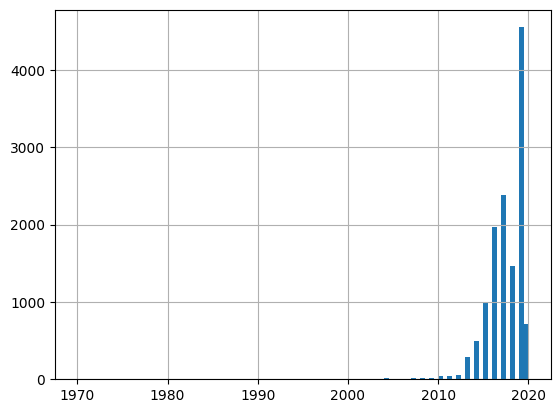

Histogram for price


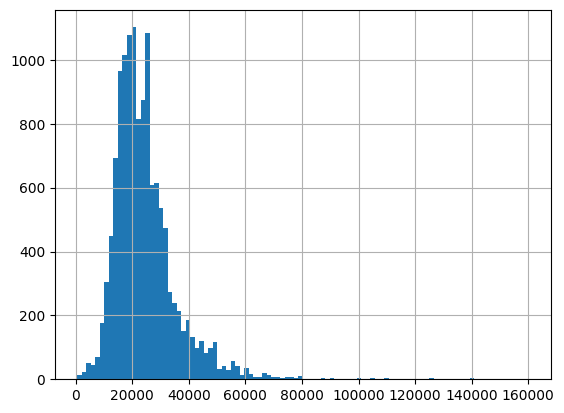

Histogram for mileage


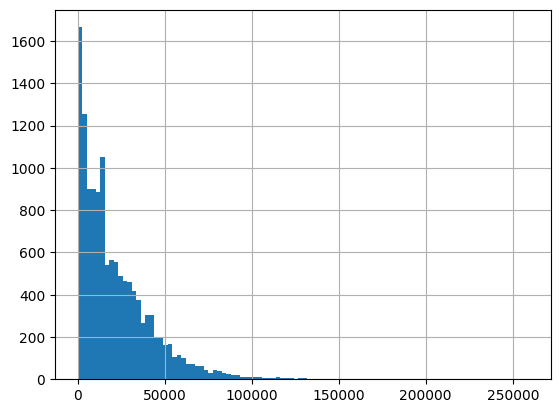

Histogram for tax


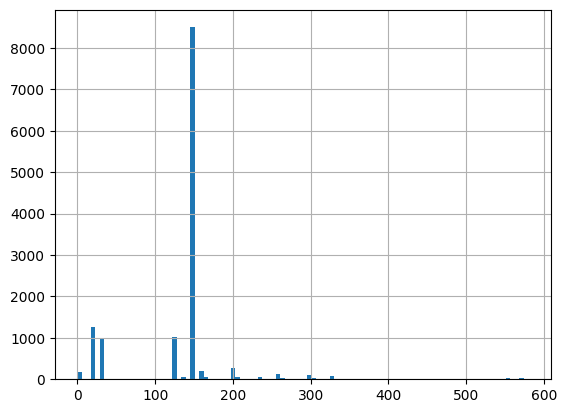

Histogram for mpg


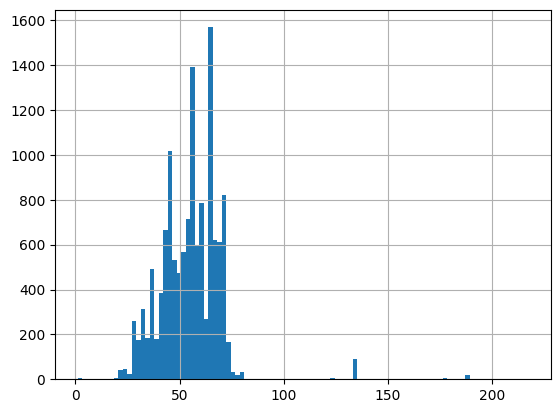

Histogram for engineSize


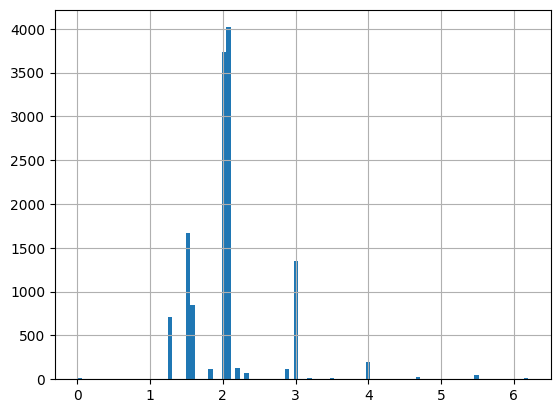

In [32]:
import matplotlib.pyplot as plt
num_cols = ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']
for col in num_cols:
    print(f'Histogram for {col}')
    df[col].hist(bins=100)
    plt.show()

Видно что в расходе топлива у нас явный выброс. Давайте найдем этот выброс с
помощью метода межквартильного расстояния. Немного статистикки:
Межквартильное расстояние это расстояние между 25 и 75 процентов в данных.

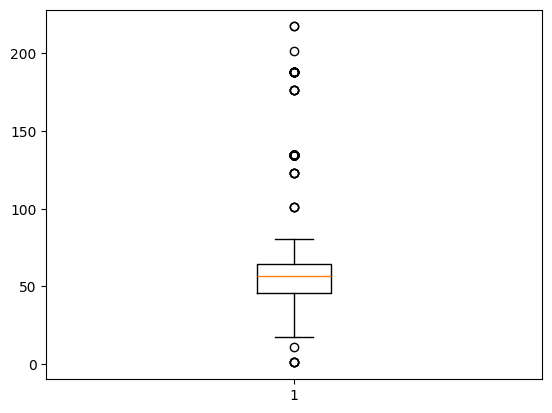

In [33]:
def calculate_iqr_boundaries(series):
    q25 = series.quantile(0.25)
    q75 = series.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries
#Посмотрим на графике
plt.boxplot(df.mpg)
plt.show()

In [34]:
#границы - все остальное выброс
mpg_bounds = calculate_iqr_boundaries(df['mpg'])
mpg_bounds

(17.7, 92.10000000000001)

In [35]:
#№Расход топлива лежащий вне этого диапозона мы можем посчитать выбросами и18 удалить.И посмотрим сколько записей останется после удаления выбросов.
df_1 = df[(df['mpg'] >= mpg_bounds[0]) & (df['mpg'] <= mpg_bounds[1])]
print(df_1.shape[0])
print(df_1.shape[0] / df.shape[0])

12990
0.9901669334552938


# Нормализация данных

In [39]:
df_1 = df[['price', 'mileage', 'tax', 'mpg']]
df_1.describe()

,price,mileage,tax,mpg
count,13119.000000,13119.000000,13119.000000,13119.000000
mean,24698.596920,21949.559037,129.972178,55.155843
std,11842.675542,21176.512267,65.260286,15.220082
min,650.000000,1.000000,0.000000,1.100000
25%,17450.000000,6097.500000,125.000000,45.600000
50%,22480.000000,15189.000000,145.000000,56.500000
75%,28980.000000,31779.500000,145.000000,64.200000
max,159999.000000,259000.000000,580.000000,217.300000


Очевидно, что признаки имеют разный масштаб. Рассмотрим первый способ —
стандартизация. Это масштабирование признака таким образом, что среднее
значение его элементов станет равно нулю, а стандартное отклонение — единица.
Соответственно у каждого признака будет свое числовое значение и свое
стандартное отклонение. Поэтому после стандартизации масштаб этих признаков
будет одинаковым.
Для стандартизации используем класс стандарт скелер.

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Масштабировать мы будем только обучающую выборку. Это делается для того,
22
чтобы проверить стандартизированные данные на реальных и понять, как работает
модель. Еще один важный момент — обычно целевую переменную не
масштабируют

In [41]:
X_train = df[['mileage', 'tax', 'mpg']]
y_train = df['price']
X_train_s = scaler.fit_transform(X_train)
X_train_s

array([[ 1.93856312,  2.98857495, -1.51488811],
       [ 0.23850167, -1.68519595,  0.41027343],
       [-0.74375606,  6.51305791, -1.78427931],
       ...,
       [-0.48818016,  0.23028393, -0.89725949],
       [-0.92197917,  0.23028393, -0.62786829],
       [-0.93855477,  0.23028393, -0.18764363]])

In [42]:
#нам вернулась матрица. Так работает метод sklearn. Давайте на ее основе создадим датафрейм
df_X_s = pd.DataFrame(X_train_s, columns=X_train.columns)
df_X_s.describe()

,mileage,tax,mpg
count,1.311900e+04,1.311900e+04,1.311900e+04
mean,6.932653e-17,5.632780e-17,-6.066071e-17
std,1.000038e+00,1.000038e+00,1.000038e+00
min,-1.036497e+00,-1.991673e+00,-3.551748e+00
25%,-7.485965e-01,-7.619285e-02,-6.278683e-01
50%,-3.192602e-01,2.302839e-01,8.831809e-02
75%,4.642084e-01,2.302839e-01,5.942479e-01
max,1.119445e+01,6.896154e+00,1.065371e+01


Давайте рассмотрим еще один пример нормализации — минимаксную
нормализацию. Чаще всего ее называют просто нормализацией. Смысл такой
нормализации — каждый признак масштабируется таким образом, что его
минимальное значение равно нулю - а максимальное — единице. Импортируем
23
специальный класс.

In [43]:
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
X_train_mm = mmscaler.fit_transform(X_train)
X_train_mm

array([[0.24324032, 0.56034483, 0.14338575],
       [0.10424365, 0.03448276, 0.27890842],
       [0.02393446, 0.95689655, 0.12442183],
       ...,
       [0.04483029, 0.25      , 0.18686401],
       [0.00936297, 0.25      , 0.20582794],
       [0.00800775, 0.25      , 0.23681776]])

In [45]:
df_sc_x = pd.DataFrame(X_train_mm, columns=X_train.columns)
df_sc_x.describe()

,mileage,tax,mpg
count,13119.000000,13119.000000,13119.000000
mean,0.084744,0.224090,0.250027
std,0.081763,0.112518,0.070398
min,0.000000,0.000000,0.000000
25%,0.023539,0.215517,0.205828
50%,0.058641,0.250000,0.256244
75%,0.122697,0.250000,0.291859
max,1.000000,1.000000,1.000000


# Работа с категориальными признаками

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13119 entries, 0 to 13118
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         13119 non-null  object 
 1   year          13119 non-null  int64  
 2   price         13119 non-null  int64  
 3   transmission  13119 non-null  object 
 4   mileage       13119 non-null  int64  
 5   fuelType      13119 non-null  object 
 6   tax           13119 non-null  int64  
 7   mpg           13119 non-null  float64
 8   engineSize    13119 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 922.6+ KB


In [49]:
df.describe(include=['object'])

,model,transmission,fuelType
count,13119,13119,13119
unique,27,4,4
top,C Class,Semi-Auto,Diesel
freq,3747,6848,9187


In [50]:
#Давайте посмотрим на список значений каждого признака
cat_features = ['model', 'transmission', 'fuelType']
for feat in cat_features:
    print(f'{feat}: {df[feat].unique()}')

model: [' SLK' ' S Class' ' SL CLASS' ' G Class' ' GLE Class' ' GLA Class'
 ' A Class' ' B Class' ' GLC Class' ' C Class' ' E Class' ' GL Class'
 ' CLS Class' ' CLC Class' ' CLA Class' ' V Class' ' M Class' ' CL Class'
 ' GLS Class' ' GLB Class' ' X-CLASS' '180' ' CLK' ' R Class' '230' '220'
 '200']
transmission: ['Automatic' 'Manual' 'Semi-Auto' 'Other']
fuelType: ['Petrol' 'Hybrid' 'Diesel' 'Other']


Рассмотрим несколько видов использования категориальных данных в модели. Для
начала нам нужно научиться преобразовывать категориальные данные в числа.
Начнем с самого простого метода label encoding. Этот метод просто, потому что мы
просто нумеруем список значений категориального признака. Давайте рассмотрим
этот прием на примере модели автомобиля.
Импортируем класс предпроцессор label encoder

In [52]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
#Теперь создадим новый признак соответствующий закодированным признакаммодели
df['model_le'] = encoder.fit_transform(df['model'])
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,model_le
0,SLK,2005,5200,Automatic,63000,Petrol,325,32.1,1.8,20
1,S Class,2017,34948,Automatic,27000,Hybrid,20,61.4,2.1,18
2,SL CLASS,2016,49948,Automatic,6200,Petrol,555,28.0,5.5,19
3,G Class,2016,61948,Automatic,16000,Petrol,325,30.4,4.0,9
4,G Class,2016,73948,Automatic,4000,Petrol,325,30.1,4.0,9


In [53]:
encoder.classes_

array([' A Class', ' B Class', ' C Class', ' CL Class', ' CLA Class',
       ' CLC Class', ' CLK', ' CLS Class', ' E Class', ' G Class',
       ' GL Class', ' GLA Class', ' GLB Class', ' GLC Class',
       ' GLE Class', ' GLS Class', ' M Class', ' R Class', ' S Class',
       ' SL CLASS', ' SLK', ' V Class', ' X-CLASS', '180', '200', '220',
       '230'], dtype=object)

In [54]:
for i, e in enumerate(encoder.classes_):
    print(f'{i}: {e}')

0:  A Class
1:  B Class
2:  C Class
3:  CL Class
4:  CLA Class
5:  CLC Class
6:  CLK
7:  CLS Class
8:  E Class
9:  G Class
10:  GL Class
11:  GLA Class
12:  GLB Class
13:  GLC Class
14:  GLE Class
15:  GLS Class
16:  M Class
17:  R Class
18:  S Class
19:  SL CLASS
20:  SLK
21:  V Class
22:  X-CLASS
23: 180
24: 200
25: 220
26: 230


При таком кодировании есть большой минус label encoder явно вносит отношение
сравнения в категории. То есть v class будет лучше, чем c class в семь раз.
Естественно в реальности таких отношений между категориями не существует, но
модель будет считать что они есть, и делать неправильные выводы.
Поэтому label encoding применяют для тех признаков, у которых явно есть
отношения сравнения. Например, анкетирования или соц опросы, в которых есть
ответы плохо, хорошо, нейтрально. Здесь явно есть отношения зависимости, так как
хорошо, это точно лучше, чем нейтрально.

Мы воспользуемся другим методом — one-hot encoding. Рассмотрим его на примере
типа топлива. Идея такого метода в том, что вместо одного категориального
признака с тремя категориями мы создаем три бинарных признака — по одному
признаку на каждое значение категории и заполняем их так, что в каждой строке
единицей заполняется тот признак, который соответствует исходному значению
категории, а остальные заполняются нулями. Давайте посмотрим как это работает.
И

In [58]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
ft = ohe.fit_transform(df[['fuelType']])
df_ft = pd.DataFrame(ft, columns=ohe.get_feature_names_out())
df_ft.head()

,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
